# Emotion recognition using NLP: Affective Computing 2023

Danila Goncharenko, 2303788

Ana Ferreira, 2308587

Luca Hustiuc, 2209104

## Traditional ML methods

Classifying short messages into five emotion categories. We will prepare our dataset (nltk and regular expressions) and vectorize words using TF-IDF (term frequency-inverse document frequency) metric. Later we will use classifiers provided by scikit-learn and classify sentences into five emotion categories: joy, sadness, anger, fear, and neutral.

### Workflow 
* Importing Dataset
* Text Preprocessing
* Text Representation
* Classifiers: Naive Bayes, Linear Regression, Random Rorrrest, SVM
* Evaluation: F1 scores and Confussion Matrix
* Saving the Model


In [2]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk import word_tokenize

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# feature extraction / vectorization
from sklearn.feature_extraction.text import TfidfVectorizer # , CountVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression #, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

In [4]:
df = pd.read_pickle('clean_data.pkl')

## 1. Import Dataset

Text-Emotion Dataset was split into training 80% and testing 20%


In [9]:
from sklearn.model_selection import train_test_split

# Define the class names
class_names = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise', 'neutral']

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# # Initialize empty DataFrames to store the train and test data
# df_train = pd.DataFrame(columns=['text', 'emotions'])
# df_test = pd.DataFrame(columns=['text', 'emotions'])

# # Iterate over each class to split the data
# for emotion in class_names:
#     # Filter the data for the current class
#     class_data = df[df['emotions'] == emotion]
    
#     # Split the data into train and test for the current class
#     class_train, class_test = train_test_split(class_data, test_size=0.3, random_state=42)
    
#     # Take only 14,971 samples for the training set
#     class_train = class_train.head(15000)
    
#     # Append the split data to the overall train and test DataFrames
#     df_train = pd.concat([df_train, class_train])
#     df_test = pd.concat([df_test, class_test])

# Shuffle the training and validation data
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features (X) and labels (y) for both sets
X_train = df_train['text']
X_test = df_test['text']
y_train = df_train['emotions']
y_test = df_test['emotions']

# Print the size of the training and validation sets
print('Size of the training set: %s' % len(X_train))
print('Size of the validation set: %s' % len(X_test))

data = pd.concat([df_train, df_test])
print(data.emotions.value_counts())

data.head()

Size of the training set: 30084
Size of the validation set: 7522
emotions
sadness     6000
joy         6000
surprise    6000
anger       6000
love        6000
fear        6000
neutral     1606
Name: count, dtype: int64


,text,emotions
0,i think i do well i see the grade and feel lik...,sadness
1,i didn t have feelings for them but seriously ...,joy
2,i was still feeling discouraged until i measur...,sadness
3,i know a part of that comes from the pride and...,surprise
4,i feel passionate about something i speak in a...,joy


In [10]:
print("Train", df_train.emotions.value_counts())
print("Test", df_test.emotions.value_counts())

Train emotions
sadness     4821
surprise    4818
anger       4813
fear        4789
joy         4782
love        4780
neutral     1281
Name: count, dtype: int64
Test emotions
love        1220
joy         1218
fear        1211
anger       1187
surprise    1182
sadness     1179
neutral      325
Name: count, dtype: int64


### Plotting confusion matrix for later evaluation 

In [11]:
def plot_confusion_matrix(y_predicted):
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_predicted) * 100))
    print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_predicted, average='micro') * 100))
    print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_predicted))

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_predicted)

    # Normalize the confusion matrix
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Create a figure and axis
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust the font size for better visualization
    sns.heatmap(conf_matrix, annot=True, cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, fmt=".2%")

    # Add labels and a title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')

## 2. Text Preprocessing

Here are some preprocessing steps to consider:
* Removing noise: html markups, urls, non-ascii symbols, trailing whitespace etc.
* Removing punctuation
* Normalizing emoticons
* Negation handling
* Tokenization: split text into word tokens
* Stopword removal
* Stemming or lemmatization

However, most of these steps did not improve our classification results. Since our data was mostly taken from written dialogs it was almost ready to use.

In [12]:
def preprocess_and_tokenize(data):    
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    tokenized = word_tokenize(data)
        
    return tokenized

## 3. Text Representation

Vectorizing text using Term Frequency technique (Term Frequency(TF) — Inverse Dense Frequency(IDF))
* Tekenize with our preprocess_and_tokenize
* Find it’s TF = (Number of repetitions of word in a document) / (# of words in a document)
* IDF = log(# of documents / # of documents containing the word)

In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [14]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

# 6m 5.6s

# 47.9s balanced

C:\Users\Dan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## 4. Classifiers

###  Naive Bayes

In [15]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

# plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
# plt.show()

Accuracy: 78.52%

F1 Score: 78.52

COnfusion Matrix:
 [[ 929   77   23   57    0   45   56]
 [  21 1012    9   31    0   22  116]
 [  27   61  825  190    0   24   91]
 [   2    6   27 1154    0    7   24]
 [ 102   23   76   32    1   64   27]
 [  65   73   33   71    0  864   73]
 [   2   32    6   17    0    4 1121]]


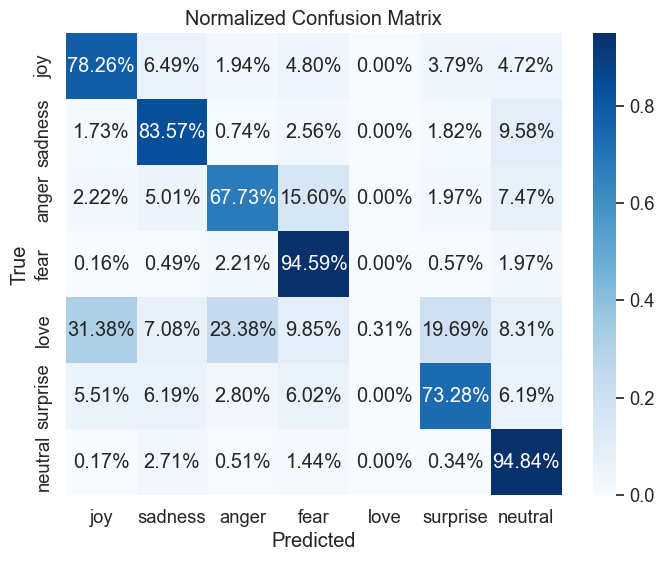

In [16]:

plot_confusion_matrix(ynb_pred)
# Show the plot
plt.show()

###  Random Forrest

In [19]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

# 1 estimator = 19.2 s

# 10 estimators = 3m 13.9s

Accuracy: 67.69%

F1 Score: 67.69

COnfusion Matrix:
 [[813  80  78  35  87  70  24]
 [ 77 874  75  23   0  58 104]
 [125 105 673 138  49  88  40]
 [ 52  45 180 888   0  35  20]
 [  4   1   2   0 317   0   1]
 [145 113 189  61  62 585  24]
 [ 35  88  60  27   0  30 942]]


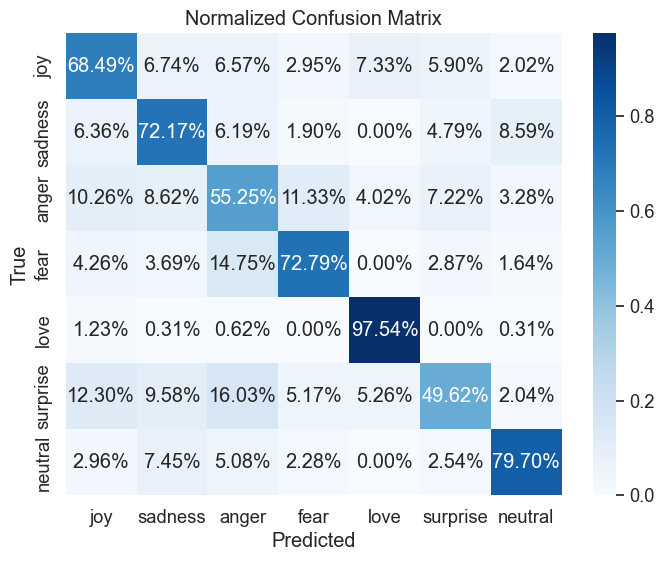

In [20]:
plot_confusion_matrix(yrf_pred)

# Show the plot
plt.show()

###  Logistic Regression

In [21]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

#3m 28.6s

Accuracy: 87.16%

F1 Score: 87.16

COnfusion Matrix:
 [[ 996   42   23    8   79   28   11]
 [  36 1015   21   10    1   30   98]
 [  18   18  975   96   48   33   30]
 [   6    4   37 1155    0   12    6]
 [   5    1    7    2  309    0    1]
 [  48   33   39   31   51  972    5]
 [   3   34    4    4    0    3 1134]]


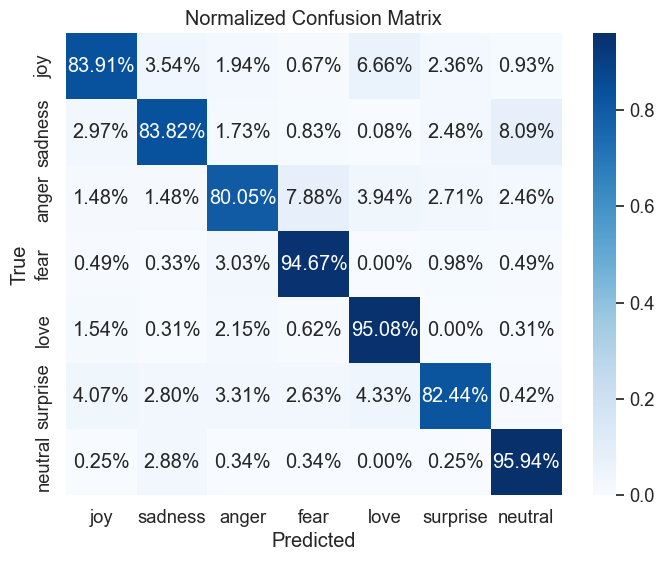

In [22]:
plot_confusion_matrix(ylog_pred)

# Show the plot
plt.show()

###  Linear Support Vector

In [23]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

Accuracy: 89.31%

F1 Score: 89.31

COnfusion Matrix:
 [[1026   38   15    6   67   27    8]
 [  22 1059    9    3    2   17   99]
 [  13   13 1004   99   40   20   29]
 [   4    3   26 1177    0    4    6]
 [   3    2    7    3  307    2    1]
 [  48   31   21   18   43 1012    6]
 [   1   39    6    1    0    2 1133]]


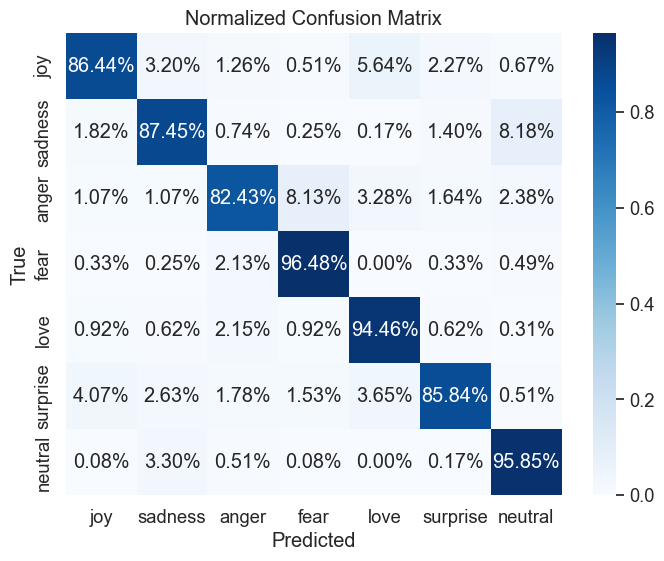

In [24]:
plot_confusion_matrix(ysvm_pred)

# Show the plot
plt.show()

## 4. Saving the tf-idf + SVM Model 


In [25]:
#Create pipeline with our tf-idf vectorizer and LinearSVC model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [26]:
# save the model
filename = 'models/new_tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [27]:
model = pickle.load(open(filename, 'rb'))

message = 'delivery was hour late and my pizza is cold!' 
model.predict([message])

array(['anger'], dtype=object)

In [28]:
message = 'I am shocked!' 
model.predict([message])

array(['surprise'], dtype=object)

In [41]:
message = 'You are so sweet!' 
model.predict([message])

array(['love'], dtype=object)

In [48]:
message = 'He has a depression.' 
model.predict([message])

array(['sadness'], dtype=object)

In [31]:
message = 'Today is my lucky day!' 
model.predict([message])

array(['joy'], dtype=object)

In [32]:
message = 'I feel really scared' 
model.predict([message])

array(['fear'], dtype=object)

In [40]:
message = 'house on the hill' 
model.predict([message])

array(['neutral'], dtype=object)

The dataset is quite small, so it may not know certain words. In additional 'fear' sentences are bias to a certain sentence structure: "I *verb* *something*". This results in overfitting and thus poor generalization of the model.

Here's an example of misclassification:

In [50]:
fear_example = df[df['emotions'] == 'fear'].tail(10)

fear_example

,text,emotions
52977,i feel a strange kinship with the sky united a...,fear
52988,i was kindof like in a daze lying there feelin...,fear
53008,i guess feeling fearful and guilty is his way ...,fear
53027,i am very at home in california there is alway...,fear
53063,i got on the plane with my hot chocolate feeli...,fear
53068,i started to feel apprehensive when the driver...,fear
53089,i feel even more unsure than i was the first t...,fear
53091,i woke up yesterday morning feeling skeptical ...,fear
53098,i even feeling insecure,fear
53099,i remember making it to food basics and sudden...,fear


In [51]:
message = 'This house is spooky!' 
model.predict([message])

array(['neutral'], dtype=object)